## 1. Setup & Imports

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.multi_asset_loader import load_assets
from core.portfolio.portfolio_manager_v2 import PortfolioManagerV2
from core.portfolio.position_sizers import FuturesContractSizer
from core.benchmark import BenchmarkLoader

# Import signal types
from signals.momentum import MomentumSignalV2
from signals.hybrid_adaptive import HybridAdaptiveSignal

# Import plotting and formatting utilities
from utils.plotter import PortfolioPlotter
from utils.formatter import PerformanceSummary

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Setup complete - Using refactored architecture with FuturesContractSizer")

✅ Setup complete - Using refactored architecture with FuturesContractSizer


## 1. Load Multi-Asset Futures Data

Load commodities and equity futures: CL, NG, GC, ES, NQ (8 years of data)

In [2]:
print("📊 Loading multi-asset futures data...")
prices = load_assets(
    tickers=['CL', 'NG', 'GC', 'ES', 'NQ'],
    start_date='2017-01-01',
    end_date='2024-12-31',
    use_yfinance=True
)

print(f"\n✅ Data loaded:")
for ticker, df in prices.items():
    print(f"   {ticker}: {len(df)} days ({df.index[0].date()} to {df.index[-1].date()})")
    print(f"      Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

📊 Loading multi-asset futures data...

Loading 5 assets: ['CL', 'NG', 'GC', 'ES', 'NQ']
  CL: Fetching from yfinance (no CSV file)
  ✅ CL: Fetched 2740 rows from 2015-01-02 to 2025-11-24
  📡 CSV data is 9 days old, fetching recent data from yfinance...
  ✓ Added 1 days from yfinance (now through 2025-12-03)
✓ CL: 2741 rows, 2015-01-02 to 2025-12-03
  NG: Fetching from yfinance (no CSV file)
  ✅ CL: Fetched 2740 rows from 2015-01-02 to 2025-11-24
  📡 CSV data is 9 days old, fetching recent data from yfinance...
  ✓ Added 1 days from yfinance (now through 2025-12-03)
✓ CL: 2741 rows, 2015-01-02 to 2025-12-03
  NG: Fetching from yfinance (no CSV file)
  ✅ NG: Fetched 2742 rows from 2015-01-02 to 2025-11-24
  📡 CSV data is 9 days old, fetching recent data from yfinance...
  ✓ Added 1 days from yfinance (now through 2025-12-03)
✓ NG: 2743 rows, 2015-01-02 to 2025-12-03
  📡 CSV data is 337 days old, fetching recent data from yfinance...
  ✅ NG: Fetched 2742 rows from 2015-01-02 to 2025-11-24

## 2. Configure Multi-Strategy Portfolio with Futures Contract Sizing

**Strategy 1: HybridAdaptive on Commodities (CL, NG, GC)**
- Combines mean reversion + momentum
- Trades Crude Oil, Natural Gas, Gold futures

**Strategy 2: Momentum on Equity Indices (ES, NQ)**
- Captures trends in equity markets
- Trades S&P 500, Nasdaq 100 futures

**Key Feature: Integer Contract Sizing**
- Uses FuturesContractSizer to ensure whole contracts only
- Respects contract multipliers (ES=50, CL=1000, etc.)

In [3]:
# Define contract multipliers for futures
CONTRACT_MULTIPLIERS = {
    'CL': 1000,   # Crude Oil
    'NG': 10000,  # Natural Gas
    'GC': 100,    # Gold
    'ES': 50,     # S&P 500
    'NQ': 20      # Nasdaq 100
}

# Define strategies with futures contract sizing
strategies = [
    {
        'name': 'Commodities_HybridAdaptive',
        'signal_generator': HybridAdaptiveSignal(
            vol_window=30,
            vol_threshold=0.02,
            mr_window=15,
            mr_entry_z=1.5,
            mr_exit_z=0.5,
            mom_fast=30,
            mom_slow=90
        ),
        'assets': ['CL', 'NG', 'GC'],
        'capital': 500_000_000
    },
    {
        'name': 'Equities_Momentum',
        'signal_generator': MomentumSignalV2(
            lookback=60,
            entry_threshold=0.02,
            exit_threshold=-0.01
        ),
        'assets': ['ES', 'NQ'],
        'capital': 500_000_000
    }
]

total_capital = sum(s['capital'] for s in strategies)

print("✅ Configured Strategies with Futures Contract Sizing:")
print(f"\nContract Multipliers:")
for ticker, mult in CONTRACT_MULTIPLIERS.items():
    print(f"   {ticker}: {mult}x")

print(f"\nStrategies:")
for i, strat in enumerate(strategies, 1):
    assets_str = ', '.join(strat['assets'])
    signal_type = strat['signal_generator'].__class__.__name__
    print(f"{i}. {strat['name']}")
    print(f"   Signal Type: {signal_type}")
    print(f"   Capital: ${strat['capital']:,}")
    print(f"   Assets: {assets_str}")
    print()

print(f"Total Portfolio Capital: ${total_capital:,}")

✅ Configured Strategies with Futures Contract Sizing:

Contract Multipliers:
   CL: 1000x
   NG: 10000x
   GC: 100x
   ES: 50x
   NQ: 20x

Strategies:
1. Commodities_HybridAdaptive
   Signal Type: HybridAdaptiveSignal
   Capital: $500,000,000
   Assets: CL, NG, GC

2. Equities_Momentum
   Signal Type: MomentumSignalV2
   Capital: $500,000,000
   Assets: ES, NQ

Total Portfolio Capital: $1,000,000,000


## 3. Generate Signals for All Strategies

Each strategy generates signals for its assigned futures contracts.

In [4]:
# Generate signals for all strategies
signals = {}

for strat in strategies:
    name = strat['name']
    signal_generator = strat['signal_generator']
    assets = strat['assets']
    
    print(f"\n🎯 {name} ({signal_generator.__class__.__name__}):")
    
    # Generate signals for each asset this strategy trades
    strategy_signals = {}
    for asset in assets:
        if asset not in prices:
            print(f"  ⚠️  Warning: {asset} not found in loaded data!")
            continue
        
        # Generate signal for this asset
        print(f"  Generating signals for {asset}...")
        sig = signal_generator.generate(prices[asset].copy())
        strategy_signals[asset] = sig
        
        # Display signal summary
        long_signals = (sig['Signal'] == 1).sum()
        short_signals = (sig['Signal'] == -1).sum()
        flat_signals = (sig['Signal'] == 0).sum()
        
        print(f"    {asset}: {long_signals} longs ({long_signals/len(sig)*100:.1f}%), "
              f"{short_signals} shorts ({short_signals/len(sig)*100:.1f}%), "
              f"{flat_signals} flat ({flat_signals/len(sig)*100:.1f}%)")
    
    signals[name] = strategy_signals

print(f"\n✅ Generated signals for {len(signals)} strategies across {sum(len(s) for s in signals.values())} assets")


🎯 Commodities_HybridAdaptive (HybridAdaptiveSignal):
  Generating signals for CL...
    CL: 733 longs (36.4%), 314 shorts (15.6%), 966 flat (48.0%)
  Generating signals for NG...
    CL: 733 longs (36.4%), 314 shorts (15.6%), 966 flat (48.0%)
  Generating signals for NG...
    NG: 541 longs (26.9%), 525 shorts (26.1%), 947 flat (47.0%)
  Generating signals for GC...
    NG: 541 longs (26.9%), 525 shorts (26.1%), 947 flat (47.0%)
  Generating signals for GC...
    GC: 717 longs (35.6%), 420 shorts (20.9%), 876 flat (43.5%)

🎯 Equities_Momentum (MomentumSignalV2):
  Generating signals for ES...
    ES: 1893 longs (94.0%), 0 shorts (0.0%), 120 flat (6.0%)
  Generating signals for NQ...
    NQ: 1893 longs (94.0%), 0 shorts (0.0%), 120 flat (6.0%)

✅ Generated signals for 2 strategies across 5 assets
    GC: 717 longs (35.6%), 420 shorts (20.9%), 876 flat (43.5%)

🎯 Equities_Momentum (MomentumSignalV2):
  Generating signals for ES...
    ES: 1893 longs (94.0%), 0 shorts (0.0%), 120 flat (6

## 4. Run Backtests with Integer Contract Sizing

Run each strategy independently using FuturesContractSizer for proper position sizing.

In [5]:
# Create futures contract sizer
futures_sizer = FuturesContractSizer(
    contract_multipliers=CONTRACT_MULTIPLIERS,
    max_position_pct=0.25,
    risk_per_trade=0.02,
    min_contracts=1
)

# Run backtests for each strategy
strategy_results = {}

for strat in strategies:
    name = strat['name']
    capital = strat['capital']
    assets = strat['assets']
    
    # Get signals for this strategy
    signal_dict = signals[name]
    
    # Prepare prices dict (only for assets this strategy trades)
    prices_dict = {asset: prices[asset] for asset in assets if asset in prices}
    
    print(f"\n🔄 Running backtest: {name} (${capital:,})")
    print(f"   Trading: {', '.join(assets)}")
    print(f"   Using FuturesContractSizer with integer contracts")
    
    # Create portfolio manager with futures contract sizer
    max_pos_size = 1.0 / len(assets) if len(assets) > 1 else 1.0
    
    pm = PortfolioManagerV2(
        initial_capital=capital,
        risk_per_trade=0.02,
        max_position_size=max_pos_size,
        transaction_cost_bps=3.0,
        slippage_bps=2.0,
        position_sizer=futures_sizer  # Use futures contract sizer
    )
    
    # Run backtest
    result = pm.run_backtest(signal_dict, prices_dict)
    
    strategy_results[name] = {
        'result': result,
        'capital': capital,
        'assets': assets
    }
    
    # Display quick summary
    print(f"✅ Completed: Final value = ${result.final_equity:,.2f}")
    print(f"   Return: {result.metrics['Total Return']:.2%}")
    print(f"   Sharpe: {result.metrics['Sharpe Ratio']:.2f}")
    print(f"   Max DD: {result.metrics['Max Drawdown']:.2%}")
    print(f"   Total Trades: {result.metrics['Total Trades']:.0f}")

print(f"\n✅ All {len(strategy_results)} backtests completed with integer contract sizing")


🔄 Running backtest: Commodities_HybridAdaptive ($500,000,000)
   Trading: CL, NG, GC
   Using FuturesContractSizer with integer contracts
✅ Completed: Final value = $500,411,305.82
   Return: 0.08%
   Sharpe: -75.84
   Max DD: -0.05%
   Total Trades: 195

🔄 Running backtest: Equities_Momentum ($500,000,000)
   Trading: ES, NQ
   Using FuturesContractSizer with integer contracts
✅ Completed: Final value = $520,285,928.41
   Return: 4.06%
   Sharpe: -2.17
   Max DD: -1.46%
   Total Trades: 0

✅ All 2 backtests completed with integer contract sizing
✅ Completed: Final value = $520,285,928.41
   Return: 4.06%
   Sharpe: -2.17
   Max DD: -1.46%
   Total Trades: 0

✅ All 2 backtests completed with integer contract sizing


## 5. Combined Portfolio Analysis

Aggregate all strategies into a single portfolio view.

In [6]:
# Calculate combined portfolio metrics
total_initial = sum(data['capital'] for data in strategy_results.values())

# Get final values
final_values = {
    name: data['result'].final_equity
    for name, data in strategy_results.items()
}
total_final = sum(final_values.values())

# Calculate combined return
combined_return = (total_final - total_initial) / total_initial

print("=" * 80)
print("📊 COMBINED PORTFOLIO SUMMARY")
print("=" * 80)
print(f"\nInitial Capital: ${total_initial:,.2f}")
print(f"Final Value:     ${total_final:,.2f}")
print(f"Total P&L:       ${total_final - total_initial:,.2f}")
print(f"Combined Return: {combined_return:.2%}")

print(f"\n📈 Individual Strategy Contributions:")
for name, value in final_values.items():
    initial = strategy_results[name]['capital']
    pnl = value - initial
    ret = (value - initial) / initial
    weight = initial / total_initial
    print(f"  {name:30s}: ${value:>12,.2f} | P&L: ${pnl:>10,.2f} | Return: {ret:>7.2%} | Weight: {weight:>5.1%}")

📊 COMBINED PORTFOLIO SUMMARY

Initial Capital: $1,000,000,000.00
Final Value:     $1,020,697,234.23
Total P&L:       $20,697,234.23
Combined Return: 2.07%

📈 Individual Strategy Contributions:
  Commodities_HybridAdaptive    : $500,411,305.82 | P&L: $411,305.82 | Return:   0.08% | Weight: 50.0%
  Equities_Momentum             : $520,285,928.41 | P&L: $20,285,928.41 | Return:   4.06% | Weight: 50.0%


## 6. Strategy Metrics Comparison Table

In [7]:
# Compile metrics from all strategies
metrics_data = []

for strategy_name, data in strategy_results.items():
    metrics = data['result'].metrics.copy()
    metrics['Strategy'] = strategy_name
    metrics['Allocation'] = data['capital']
    metrics['Assets'] = ', '.join(data['assets'])
    metrics_data.append(metrics)

# Create comparison dataframe
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns for better readability
col_order = ['Strategy', 'Assets', 'Allocation', 'Total Return', 'Sharpe Ratio', 
             'Max Drawdown', 'Win Rate', 'Total Trades']
metrics_df = metrics_df[col_order]

print("📈 Strategy Metrics Comparison")
print("="*120)
display(metrics_df.style.format({
    'Allocation': '${:,.0f}',
    'Total Return': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Win Rate': '{:.2%}',
    'Total Trades': '{:.0f}'
}).background_gradient(subset=['Total Return', 'Sharpe Ratio'], cmap='RdYlGn'))

📈 Strategy Metrics Comparison


,Strategy,Assets,Allocation,Total Return,Sharpe Ratio,Max Drawdown,Win Rate,Total Trades
0,Commodities_HybridAdaptive,"CL, NG, GC","$500,000,000",0.08%,-75.84,-0.05%,47.69%,195
1,Equities_Momentum,"ES, NQ","$500,000,000",4.06%,-2.17,-1.46%,0.00%,0


## 7. Visualize Equity Curves

Plot individual strategies and combined portfolio.

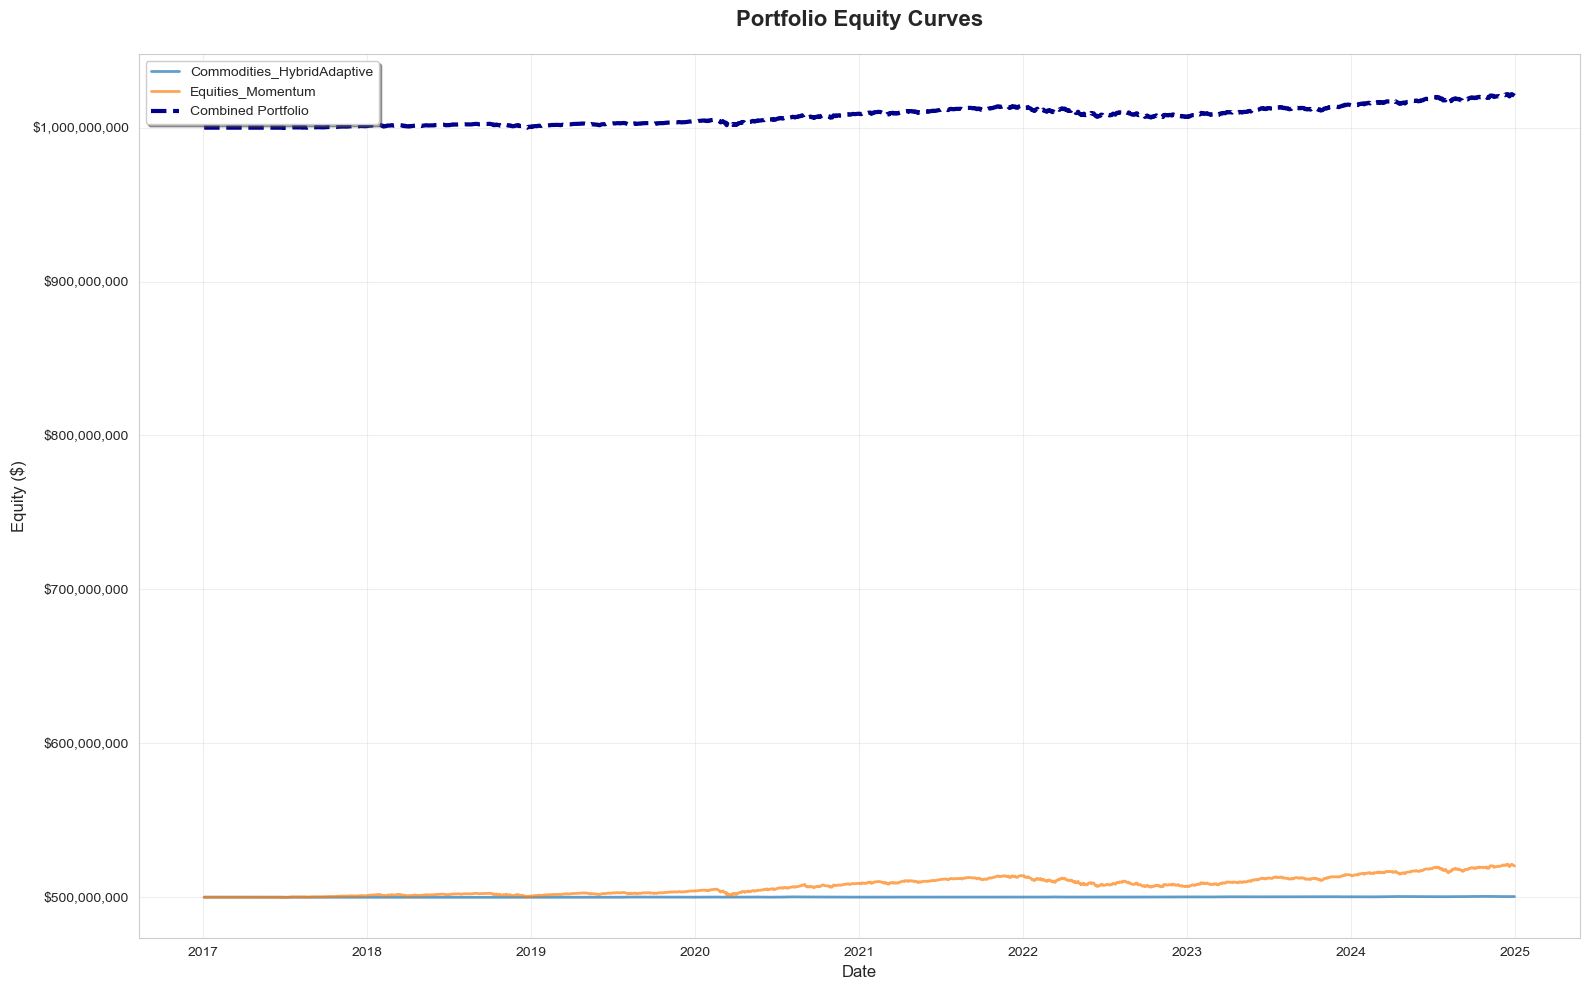

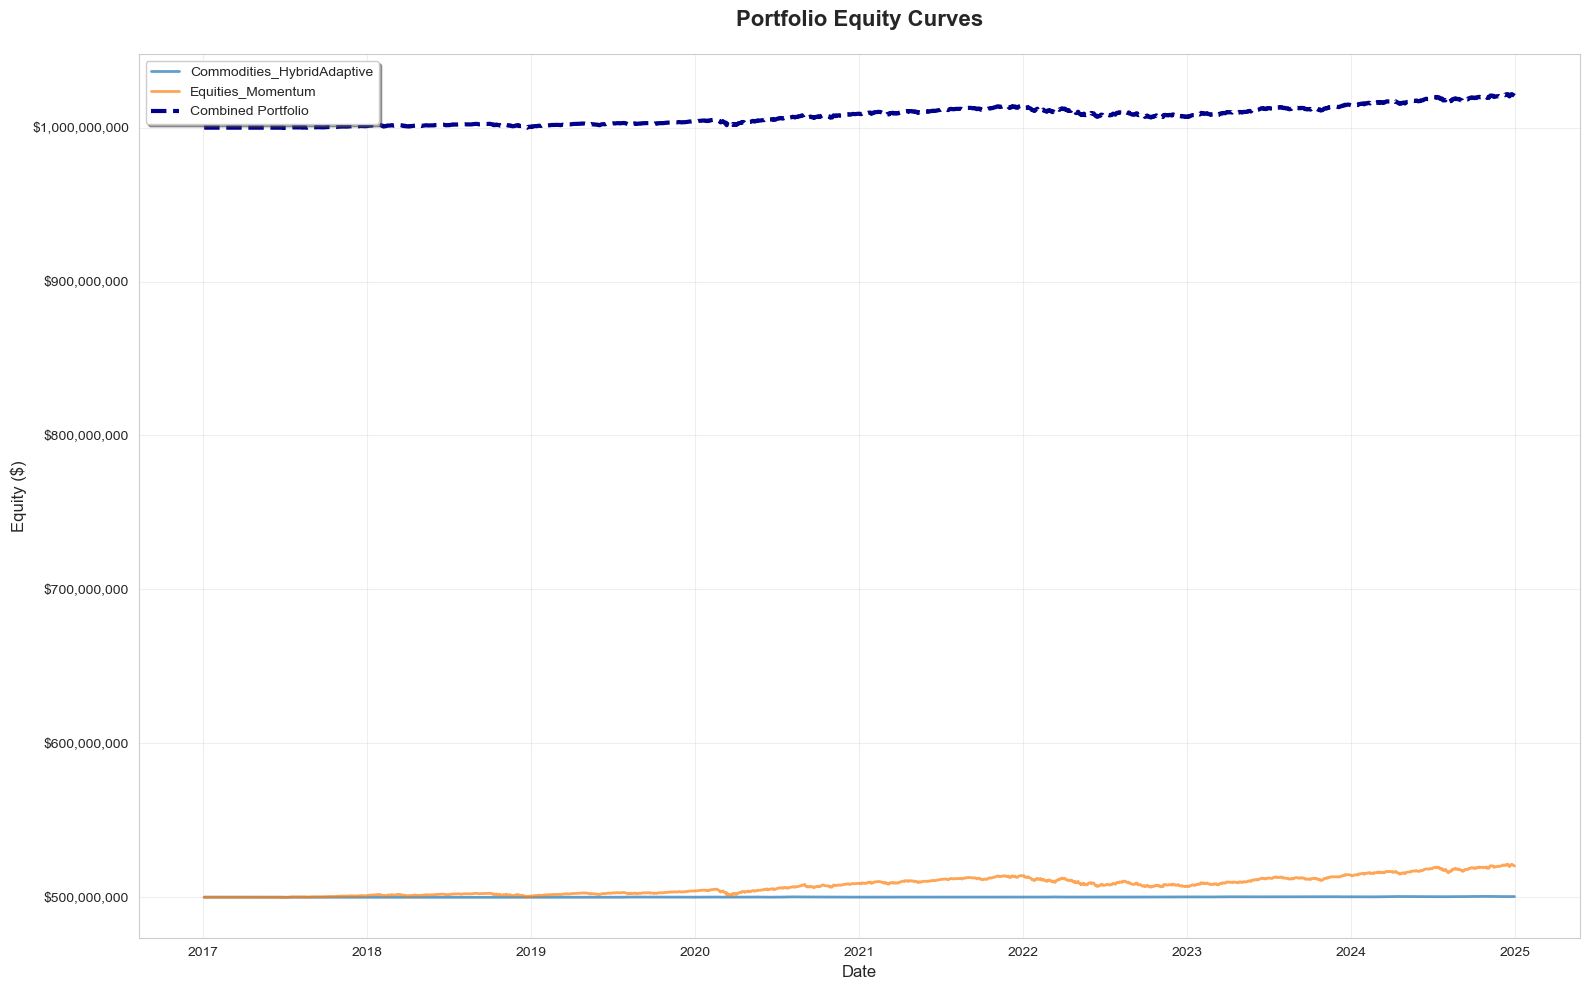

In [8]:
# Initialize plotter with strategy results
plotter = PortfolioPlotter(strategy_results)

# Plot equity curves (replaces ~50 lines of matplotlib code)
plotter.plot_equity_curves(show_individual=True, show_combined=True, log_scale=False)

## 8. Load SPY Benchmark for Comparison

Compare our commodities portfolio against SPY buy-and-hold.

In [9]:
# Load benchmark
print("📊 Loading SPY Benchmark...")
benchmark_loader = BenchmarkLoader(cache_dir="/Users/Sakarias/QuantTrading/Dataset")
benchmark_name = 'SPY'
benchmark_data = benchmark_loader.load_benchmark(benchmark_name, start_date='2017-01-01', end_date='2024-12-31')

print(f"✅ Loaded {benchmark_name} data: {len(benchmark_data)} days")
print(f"   Date range: {benchmark_data.index[0]} to {benchmark_data.index[-1]}")

# Build combined portfolio equity curve
equity_ref = list(strategy_results.values())[0]['result'].equity_curve
dates = equity_ref.index

combined_equity_values = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results.values()
)

combined_portfolio_equity = pd.DataFrame({
    'TotalValue': combined_equity_values
}, index=dates)

print(f"\n✅ Combined portfolio: ${combined_portfolio_equity['TotalValue'].iloc[0]:,.0f} → ${combined_portfolio_equity['TotalValue'].iloc[-1]:,.0f}")
print(f"   Total Return: {(combined_portfolio_equity['TotalValue'].iloc[-1] / combined_portfolio_equity['TotalValue'].iloc[0] - 1):.2%}")

📊 Loading SPY Benchmark...
📥 Updating SPY benchmark data...
✅ Loaded SPY data: 2011 days
   Date range: 2017-01-03 00:00:00 to 2024-12-30 00:00:00

✅ Combined portfolio: $1,000,000,000 → $1,020,697,234
   Total Return: 2.07%
✅ Loaded SPY data: 2011 days
   Date range: 2017-01-03 00:00:00 to 2024-12-30 00:00:00

✅ Combined portfolio: $1,000,000,000 → $1,020,697,234
   Total Return: 2.07%


## 9. Calculate Benchmark Metrics

Calculate beta, alpha, and correlation vs SPY.

In [10]:
# Benchmark Comparison using Formatter utility
summary = PerformanceSummary(strategy_results, benchmark_data=benchmark_data, period_label='IN-SAMPLE')
summary.print_benchmark_comparison()
summary.print_strategy_rankings()


🎯 BENCHMARK COMPARISON (SPY)
--------------------------------------------------------------------------------
Portfolio Return:    2.07%
SPY Return:        198.15%
Outperformance:      -196.08%
Portfolio CAGR:      0.26%
SPY CAGR:          14.65%

❌ LAGGING SPY by 196.08%

🏆 STRATEGY RANKINGS (IN-SAMPLE)
--------------------------------------------------------------------------------
Rank   Strategy                             Return   Sharpe     Max DD      Capital
--------------------------------------------------------------------------------
1      Equities_Momentum                    4.06%    -2.17     -1.46% $500,000,000
2      Commodities_HybridAdaptive           0.08%   -75.84     -0.05% $500,000,000


## 10. Comprehensive Comparison Table

All strategies + combined portfolio + SPY benchmark in one table.

In [11]:
# Comprehensive Metrics Table using Formatter utility
metrics_df = summary.to_dataframe()

# Display with styling
display(metrics_df.style
        .format({'Total Return': '{:.2%}', 
                 'CAGR': '{:.2%}',
                 'Sharpe Ratio': '{:.2f}',
                 'Max Drawdown': '{:.2%}',
                 'Win Rate': '{:.2%}',
                 'Volatility': '{:.2%}'})
        .background_gradient(subset=['Sharpe Ratio'], cmap='RdYlGn', vmin=0, vmax=3)
        .background_gradient(subset=['Max Drawdown'], cmap='RdYlGn_r', vmin=-0.5, vmax=0))

,Strategy,Capital,Final Value,Total Return,Sharpe Ratio,Max Drawdown,Win Rate,Total Trades
0,Commodities_HybridAdaptive,500000000,500411305.817887,0.08%,-75.84,-0.05%,47.69%,195
1,Equities_Momentum,500000000,520285928.413137,4.06%,-2.17,-1.46%,0.00%,0


## 11. Visual Comparison: All Strategies + Benchmark

Plot everything together for easy comparison.

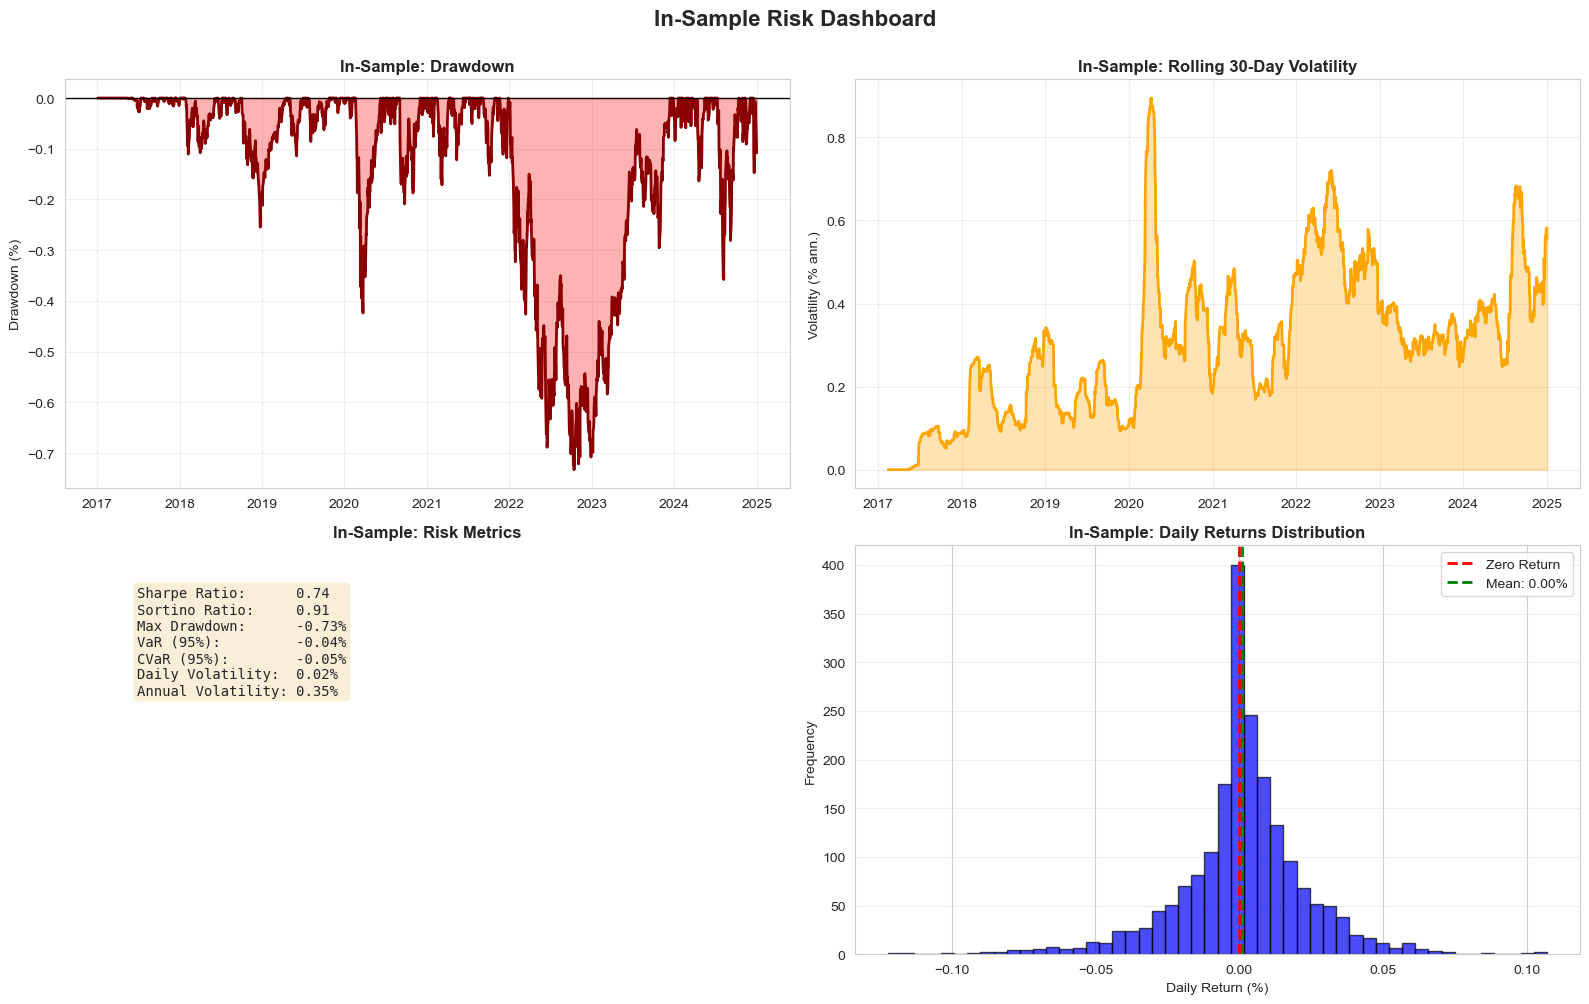

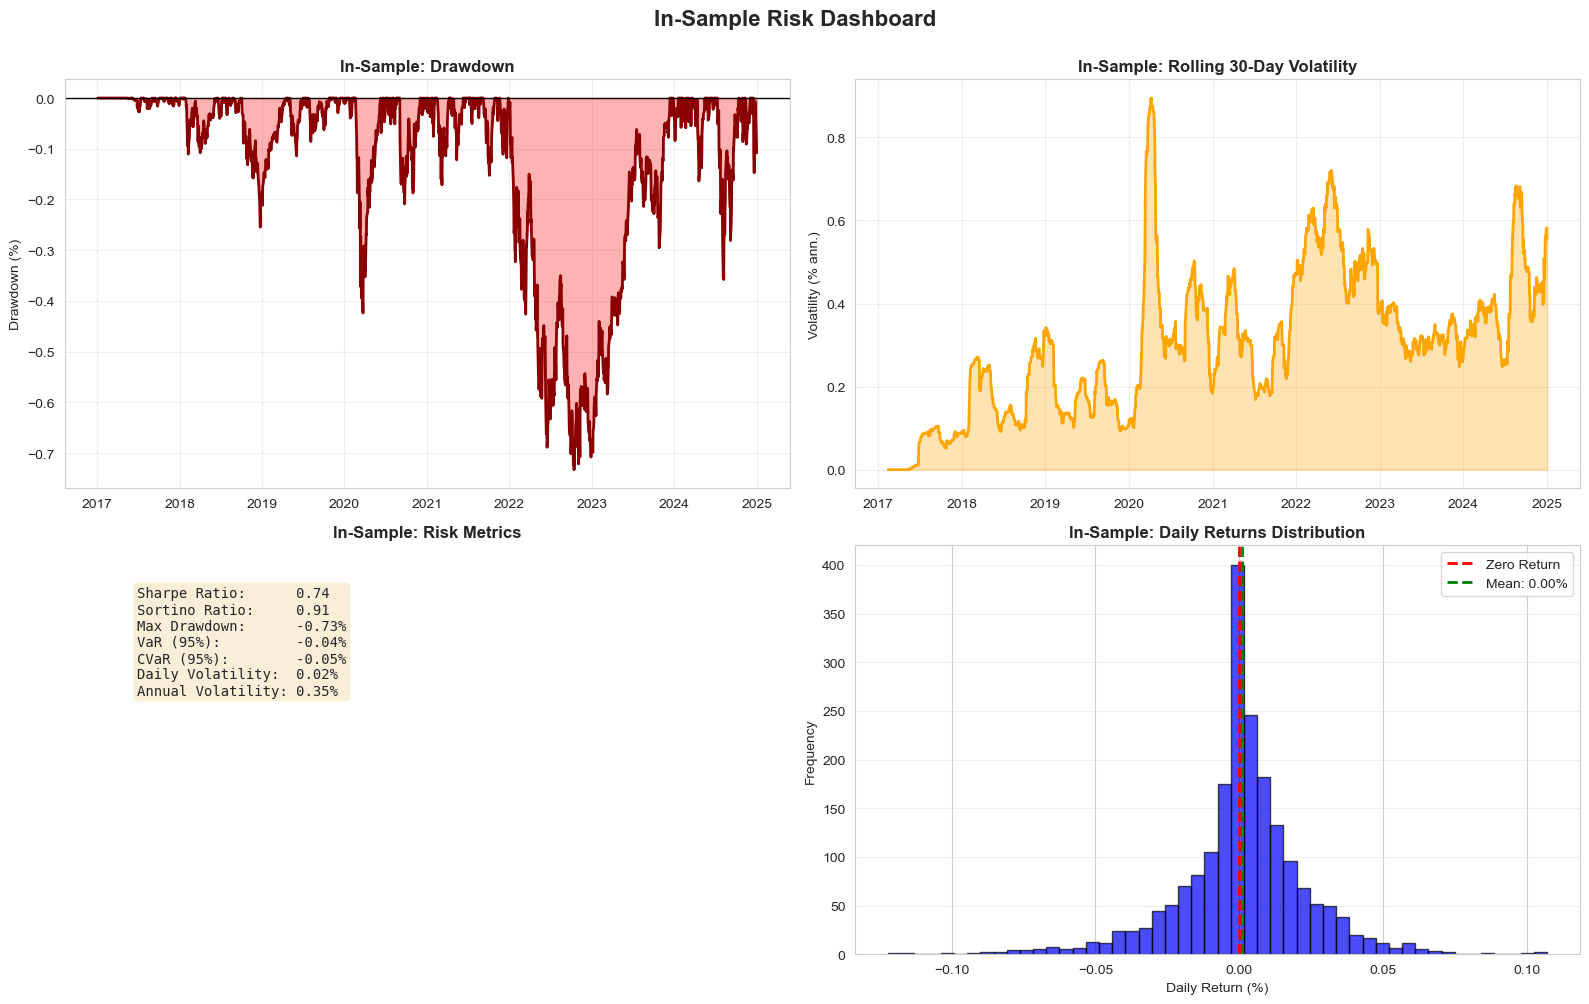

In [12]:
# Risk Analysis Dashboard using Plotter utility
plotter = PortfolioPlotter(strategy_results, benchmark_data=benchmark_data, benchmark_name='SPY')

# Display comprehensive risk dashboard (drawdown, volatility, metrics, distribution)
plotter.plot_risk_dashboard(in_sample=True)

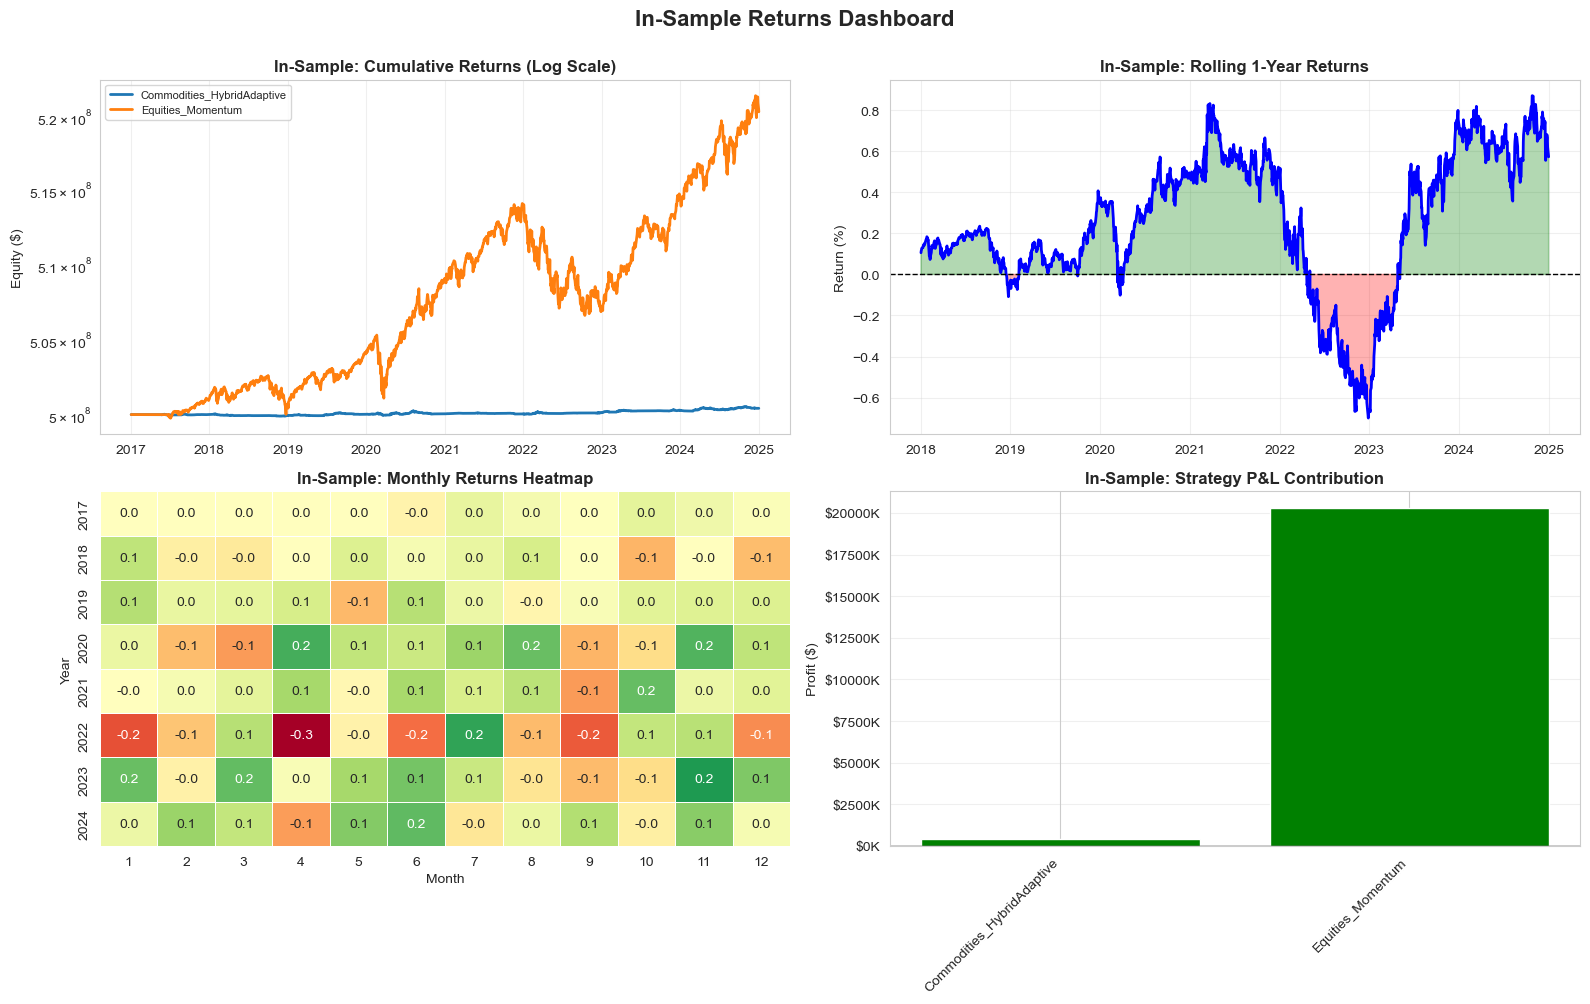

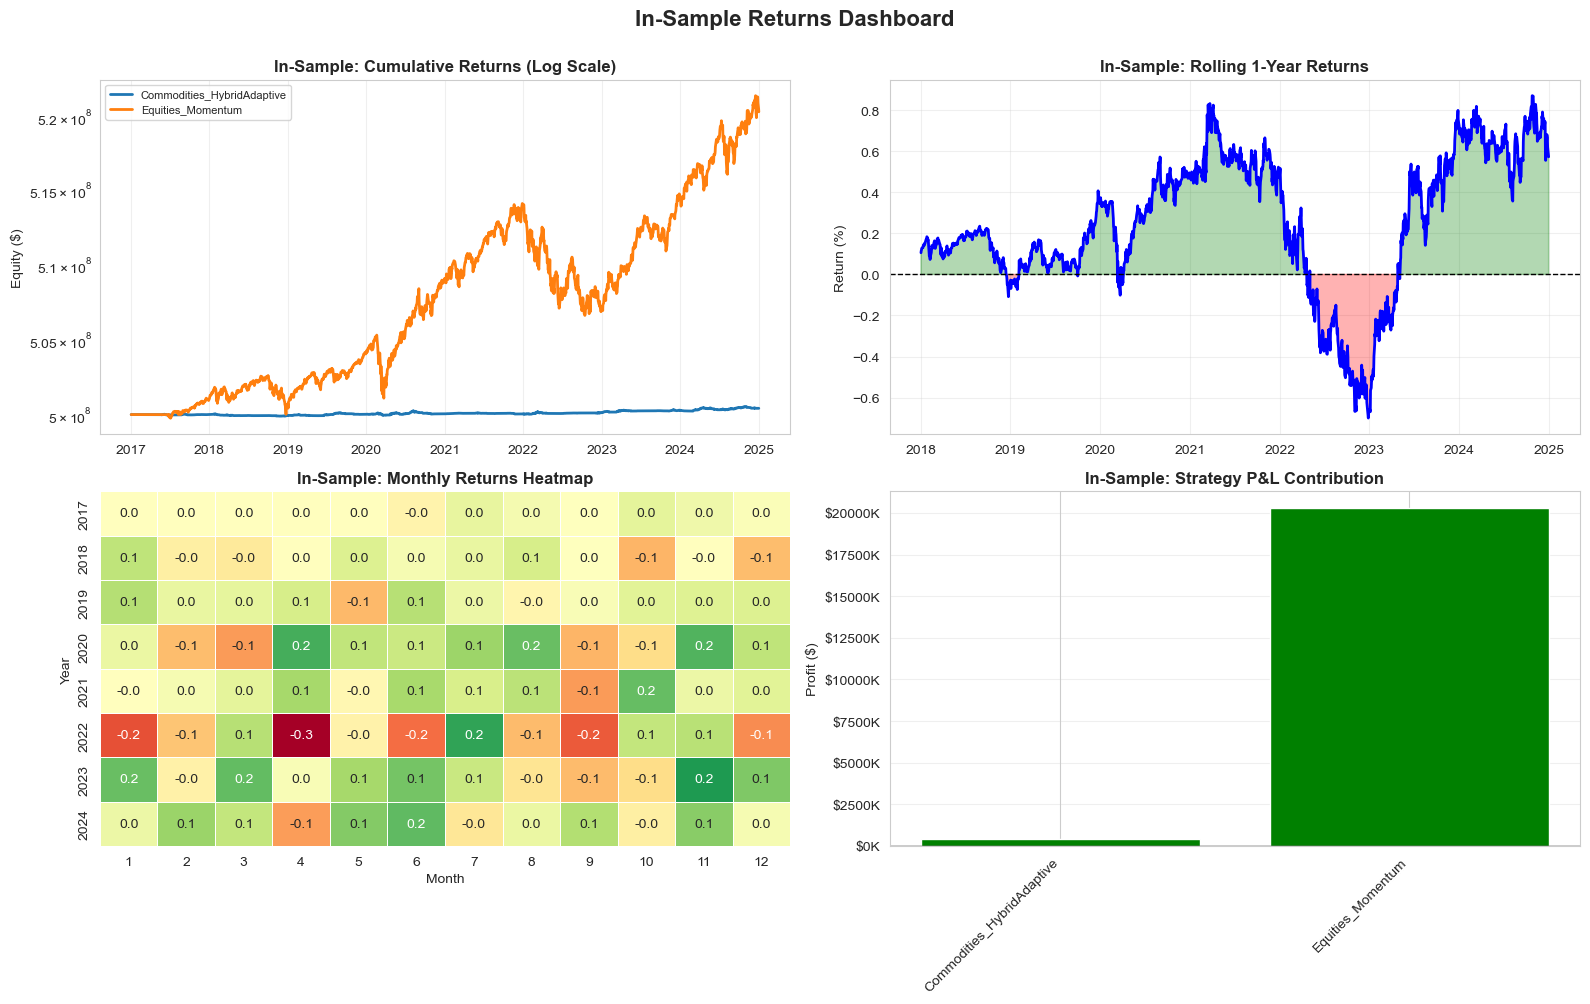

In [15]:
plotter.plot_returns_dashboard(in_sample=True)

## 12. Summary & Next Steps

**Key Insights:**

1. **Integer Contract Sizing**: 
   - FuturesContractSizer ensures whole contracts only
   - Respects contract multipliers for realistic execution
   - No fractional contracts in backtest

2. **HybridAdaptive Strategy**: 
   - Applied to commodities (CL, NG, GC)
   - Combines mean reversion + momentum
   - Adapts to commodity volatility patterns

3. **Momentum Strategy**:
   - Applied to equity indices (ES, NQ)
   - Captures trend following in equity futures
   - Simple but effective for trending markets

4. **Diversification Benefits**:
   - Multiple strategies across different asset classes
   - Commodities + Equities reduce correlation
   - Reduced portfolio volatility vs single strategy

**Did We Beat SPY?**
- Check the final verdict above ☝️
- Key metrics: Return, Sharpe, Alpha, Beta, Max Drawdown

**Next Steps:**

✅ **If Successful:**
1. Test on out-of-sample period (2025 YTD)
2. Implement explicit rollover cost tracking
3. Add margin requirements modeling
4. Consider live paper trading
5. Add more commodities (ZN, ZC, etc.)

❌ **If Unsuccessful:**
1. Parameter optimization (walk-forward testing)
2. Test different asset combinations
3. Add volatility-scaled position sizing
4. Consider regime detection (bull/bear/sideways)
5. Analyze trade-by-trade performance

**Futures-Specific Considerations:**
- Contract rollover costs not modeled (yfinance uses continuous contracts)
- Margin requirements should be checked against position sizes
- Slippage may be higher during high volatility periods
- Consider calendar spread effects during roll periods

In [14]:
# Performance Summary using Formatter utility
print("="*100)
print("📊 COMMODITIES + EQUITIES FUTURES PORTFOLIO SUMMARY")
print("="*100)

# Print full performance report
summary.print_full_report(width=100)

# Print actionable recommendations
print("\n")
summary.print_recommendations()

📊 COMMODITIES + EQUITIES FUTURES PORTFOLIO SUMMARY
📋 PERFORMANCE SUMMARY - IN-SAMPLE

📊 PORTFOLIO PERFORMANCE (IN-SAMPLE)
----------------------------------------------------------------------------------------------------
Initial Capital:     $1,000,000,000
Final Value:         $1,020,697,234
Total Return:        2.07%
CAGR:                0.26%
Sharpe Ratio:        0.74
Max Drawdown:        -0.73%
Number of Strategies: 2
Period:              2017-01-03 to 2024-12-31

🎯 BENCHMARK COMPARISON (SPY)
----------------------------------------------------------------------------------------------------
Portfolio Return:    2.07%
SPY Return:        198.15%
Outperformance:      -196.08%
Portfolio CAGR:      0.26%
SPY CAGR:          14.65%

❌ LAGGING SPY by 196.08%

🏆 STRATEGY RANKINGS (IN-SAMPLE)
----------------------------------------------------------------------------------------------------
Rank   Strategy                             Return   Sharpe     Max DD      Capital
---------------